# Invasiveness Analysis

In [1]:
import numpy as np
import pandas as pd
import skimage as ski
import scipy as sp
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
import cv2, pcdl, glob, os

In [ ]:
# custom functions
import image_processing as ip
import invasiveness as iv
import pseudo_image_utils as piu
import utils

## Processing Hypothesis 2

In [ ]:
hypo2_simulation_results_df = pd.read_csv("../output/tables/hypothesis2_invasiveness_replicates.csv")

In [82]:
## Plotting Utilities and Variables
def get_ratio_label(cat_str):
    if "only" in cat_str and "tumor" in cat_str:
        return f"1:0 Tumor:Fibroblast"
    elif "only" in cat_str and "fibroblast" in cat_str:
        return f"0:1 Tumor:Fibroblast"
    else:
        tumor = cat_str.split("_")[1]
        fibro = cat_str.split("_")[-2]
        return f"{tumor}:{fibro} Tumor:Fibroblast"

# Define jitter function to add random noise to the x-coordinates
def add_jitter(x, jitter_amount=0.1):
    return x + np.random.uniform(-jitter_amount, jitter_amount, size=len(x))

hour_markers = ['.', '^', '*', 'D', 's', 'x', 'v', '+', 'h']

# Use a color palette from Matplotlib's colormap (tab10 for 10 distinct colors)
cmap = cm.get_cmap('tab10', len(hypo2_simulation_results_df['experimental_condition'].unique()))
colors = {condition: cmap(i) for i, condition in enumerate(hypo2_simulation_results_df['experimental_condition'].unique())}
color_keys = list(colors.keys())

labels_raw = list(set(hypo2_simulation_results_df['experimental_condition']))
labels_proc = [get_ratio_label(l) for l in labels_raw]
output_labels_map = {k:p for k,p in zip(labels_raw, labels_proc)}

# setting x axis ticks and labels
xticks = list(np.unique(hypo2_simulation_results_df['hours'].values))
xlabels = sorted(list(np.unique(hypo2_simulation_results_df.index.values)), key=lambda x: int(''.join(filter(str.isdigit, x))))

/var/folders/99/8rc4_4_n7233rmjmy44dmfbs5531hj/T/ipykernel_44483/1871447310.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(all_simulation_results_df['experimental_condition'].unique()))


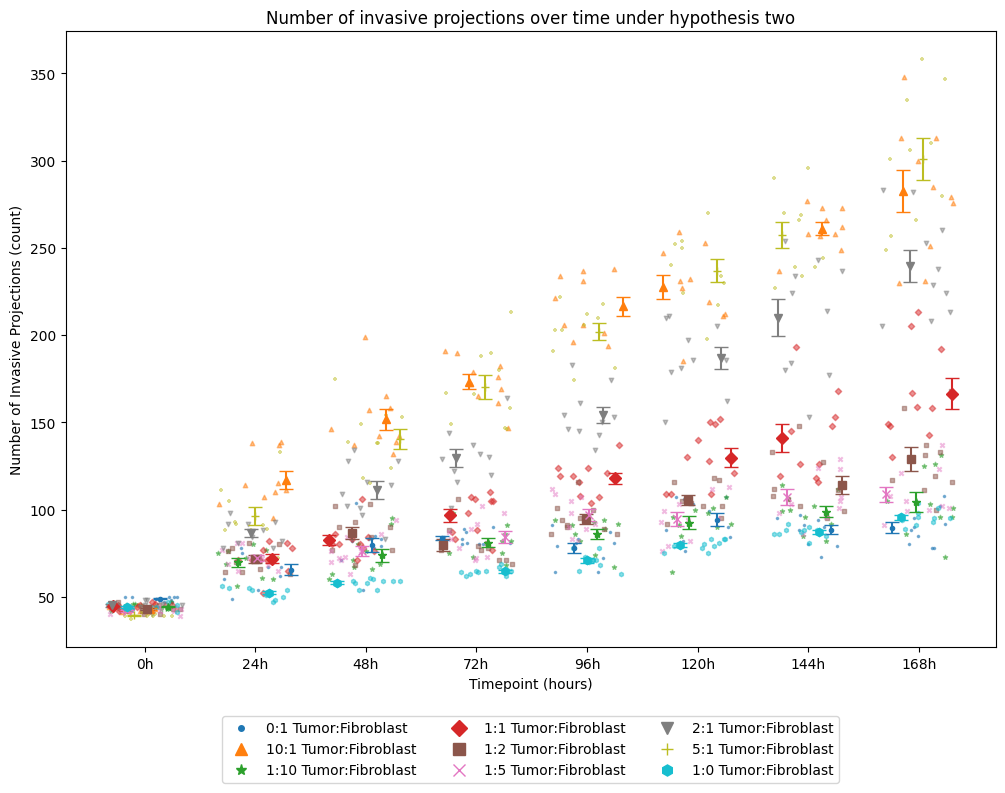

In [84]:
# Group by 'experimental_condition' and 'timepoint'
grouped = hypo2_simulation_results_df.groupby(['experimental_condition', 'hours'])

# Calculate mean and standard error for each group
mean_se_df = grouped['n_invasive_projections'].agg(['mean', 'sem']).reset_index()

# Ensure data is sorted by 'timepoint'
mean_se_df = mean_se_df.sort_values(by=['hours'])

fig, ax = plt.subplots(figsize=(12,8))

# plot the points with jitter
i=0
for key, grp in hypo2_simulation_results_df.groupby(['experimental_condition']):
    jittered_timepoints = add_jitter(grp['hours'].values, jitter_amount=8)  # Add jitter to timepoints
    ax.scatter(
        list(jittered_timepoints), 
        grp['n_invasive_projections'], 
        marker=hour_markers[i], 
        alpha=0.5, 
        label=output_labels_map[key[0]], #grp['experimental_condition'].iloc[0],
        s = 10,
        color=colors[key[0]]
        )
    i += 1

# Plot the means with standard error bars
i=0
for key, grp in mean_se_df.groupby('experimental_condition'):
    jittered_timepoints = add_jitter(grp['hours'].values, jitter_amount=8)  # Add jitter to timepoints
    # Add error bars for the mean with standard error
    ax.errorbar(
        list(jittered_timepoints), 
        grp['mean'], 
        yerr=grp['sem'], 
        fmt=hour_markers[i], 
        capsize=5, 
        alpha=1.0, 
        color=colors[key]
        )
    i+=1

# Custom legend with alpha=1
handles, labels = ax.get_legend_handles_labels()
new_handles = []
for i, handle in enumerate(handles):
    new_handle = plt.Line2D([], [], color=colors[color_keys[i]], alpha=1.0, marker=hour_markers[i], linestyle='', markersize=8)
    new_handles.append(new_handle)

# Move the legend to below the x-axis
ax.legend(new_handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

# set the axis ticks and labels
ax.set_xticks(xticks)  # Set the ticks
ax.set_xticklabels(xlabels)  # Set the tick labels
ax.set_title("Number of invasive projections over time under hypothesis two")
ax.set_xlabel("Timepoint (hours)")
ax.set_ylabel("Number of Invasive Projections (count)")
plt.show()

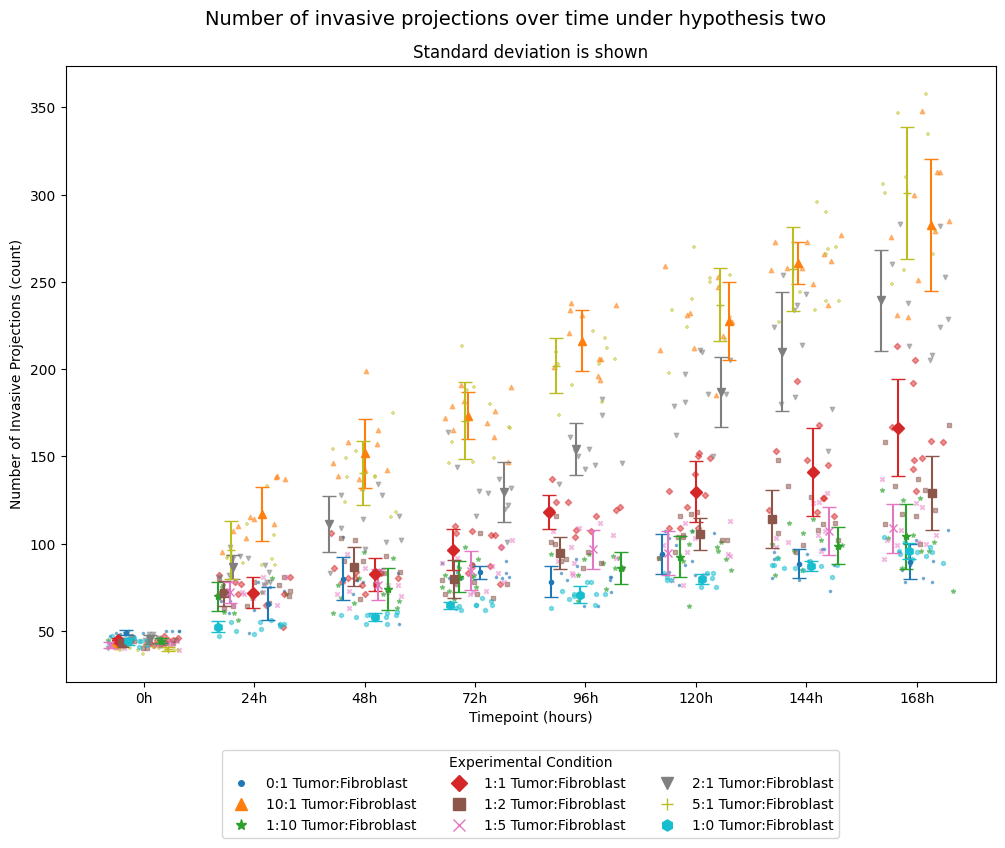

In [104]:
## Repeat of graph above, but using the standard deviation instead of the sem
# Group by 'experimental_condition' and 'timepoint'
grouped = hypo2_simulation_results_df.groupby(['experimental_condition', 'hours'])

# Calculate mean and standard error for each group
mean_se_df = grouped['n_invasive_projections'].agg(['mean', 'std']).reset_index()

# Ensure data is sorted by 'timepoint'
mean_se_df = mean_se_df.sort_values(by=['hours'])

fig, ax = plt.subplots(figsize=(12,8))

# plot the points with jitter
i=0
for key, grp in hypo2_simulation_results_df.groupby(['experimental_condition']):
    jittered_timepoints = add_jitter(grp['hours'].values, jitter_amount=8)  # Add jitter to timepoints
    ax.scatter(
        list(jittered_timepoints), 
        grp['n_invasive_projections'], 
        marker=hour_markers[i], 
        alpha=0.5, 
        label=output_labels_map[key[0]], #grp['experimental_condition'].iloc[0],
        s = 10,
        color=colors[key[0]]
        )
    i += 1

# Plot the means with standard error bars
i=0
for key, grp in mean_se_df.groupby('experimental_condition'):
    jittered_timepoints = add_jitter(grp['hours'].values, jitter_amount=8)  # Add jitter to timepoints
    # Add error bars for the mean with standard error
    ax.errorbar(
        list(jittered_timepoints), 
        grp['mean'], 
        yerr=grp['std'], 
        fmt=hour_markers[i], 
        capsize=5, 
        alpha=1.0, 
        color=colors[key]
        )
    i+=1

# Custom legend with alpha=1
handles, labels = ax.get_legend_handles_labels()
new_handles = []
for i, handle in enumerate(handles):
    new_handle = plt.Line2D([], [], color=colors[color_keys[i]], alpha=1.0, marker=hour_markers[i], linestyle='', markersize=8)
    new_handles.append(new_handle)

# Move the legend to below the x-axis
ax.legend(new_handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, title="Experimental Condition")

# set the axis ticks and labels
ax.set_xticks(xticks)  # Set the ticks
ax.set_xticklabels(xlabels)  # Set the tick labels
ax.set_title("Standard deviation is shown")
ax.set_xlabel("Timepoint (hours)")
ax.set_ylabel("Number of Invasive Projections (count)")
fig.suptitle("Number of invasive projections over time under hypothesis two", fontsize=14, y=0.95)
plt.show()

## Processing Hypothesis 1 

In [ ]:
hypo1_simulation_results_df = pd.read_csv("../output/tables/hypothesis1_invasiveness_replicates.csv")

In [90]:
# Use a color palette from Matplotlib's colormap (tab10 for 10 distinct colors)
cmap = cm.get_cmap('tab10', len(hypo1_simulation_results_df['experimental_condition'].unique()))
colors = {condition: cmap(i) for i, condition in enumerate(hypo1_simulation_results_df['experimental_condition'].unique())}
color_keys = list(colors.keys())

labels_raw = list(set(hypo1_simulation_results_df['experimental_condition']))
labels_proc = [get_ratio_label(l) for l in labels_raw]
output_labels_map = {k:p for k,p in zip(labels_raw, labels_proc)}

# setting x axis ticks and labels
xticks = list(np.unique(hypo1_simulation_results_df['hours'].values))
xlabels = sorted(list(np.unique(hypo1_simulation_results_df.index.values)), key=lambda x: int(''.join(filter(str.isdigit, x))))

/var/folders/99/8rc4_4_n7233rmjmy44dmfbs5531hj/T/ipykernel_44483/964299990.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(hypo1_simulation_results_df['experimental_condition'].unique()))


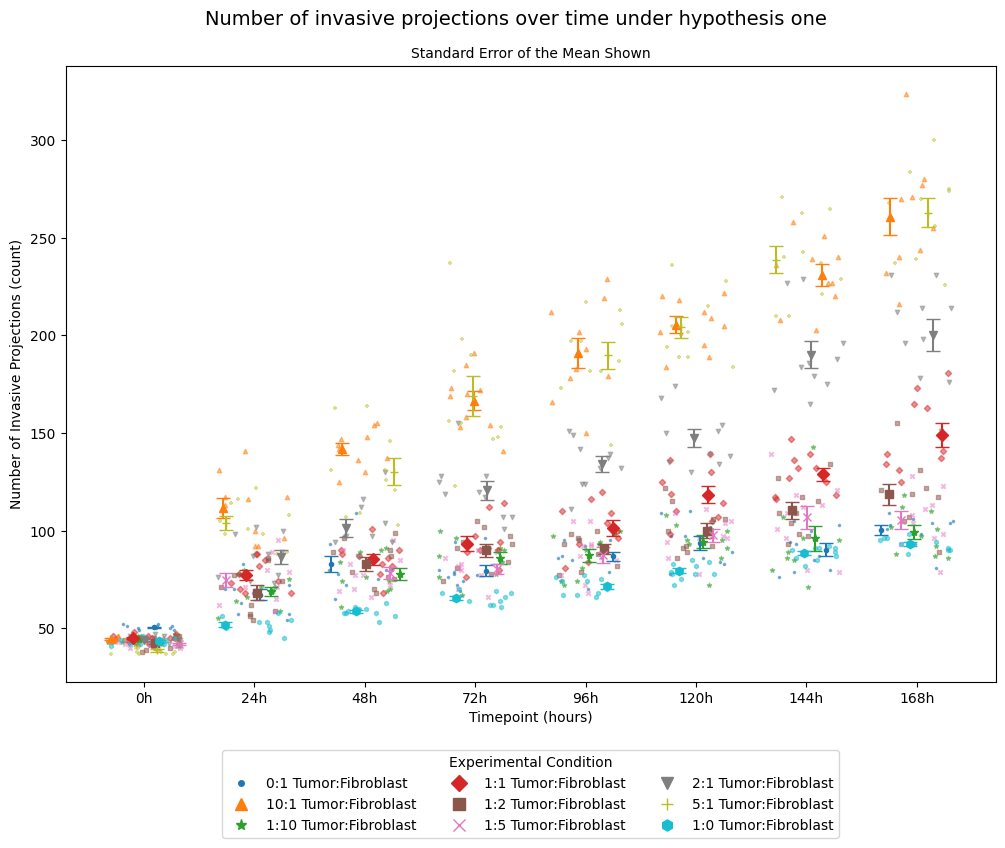

In [102]:
# Group by 'experimental_condition' and 'timepoint'
grouped = hypo1_simulation_results_df.groupby(['experimental_condition', 'hours'])

# Calculate mean and standard error for each group
mean_se_df = grouped['n_invasive_projections'].agg(['mean', 'sem']).reset_index()

# Ensure data is sorted by 'timepoint'
mean_se_df = mean_se_df.sort_values(by=['hours'])

fig, ax = plt.subplots(figsize=(12,8))

# plot the points with jitter
i=0
for key, grp in hypo1_simulation_results_df.groupby(['experimental_condition']):
    jittered_timepoints = add_jitter(grp['hours'].values, jitter_amount=8)  # Add jitter to timepoints
    ax.scatter(
        list(jittered_timepoints), 
        grp['n_invasive_projections'], 
        marker=hour_markers[i], 
        alpha=0.5, 
        label=output_labels_map[key[0]], #grp['experimental_condition'].iloc[0],
        s = 10,
        color=colors[key[0]]
        )
    i += 1

# Plot the means with standard error bars
i=0
for key, grp in mean_se_df.groupby('experimental_condition'):
    jittered_timepoints = add_jitter(grp['hours'].values, jitter_amount=8)  # Add jitter to timepoints
    # Add error bars for the mean with standard error
    ax.errorbar(
        list(jittered_timepoints), 
        grp['mean'], 
        yerr=grp['sem'], 
        fmt=hour_markers[i], 
        capsize=5, 
        alpha=1.0, 
        color=colors[key]
        )
    i+=1

# Custom legend with alpha=1
handles, labels = ax.get_legend_handles_labels()
new_handles = []
for i, handle in enumerate(handles):
    new_handle = plt.Line2D([], [], color=colors[color_keys[i]], alpha=1.0, marker=hour_markers[i], linestyle='', markersize=8)
    new_handles.append(new_handle)

# Move the legend to below the x-axis
ax.legend(new_handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, title="Experimental Condition")

# set the axis ticks and labels
ax.set_xticks(xticks)  # Set the ticks
ax.set_xticklabels(xlabels)  # Set the tick labels
ax.set_title("Standard Error of the Mean Shown", fontsize=10)
ax.set_xlabel("Timepoint (hours)")
ax.set_ylabel("Number of Invasive Projections (count)")
fig.suptitle("Number of invasive projections over time under hypothesis one", y=0.95, fontsize=14)
plt.show()

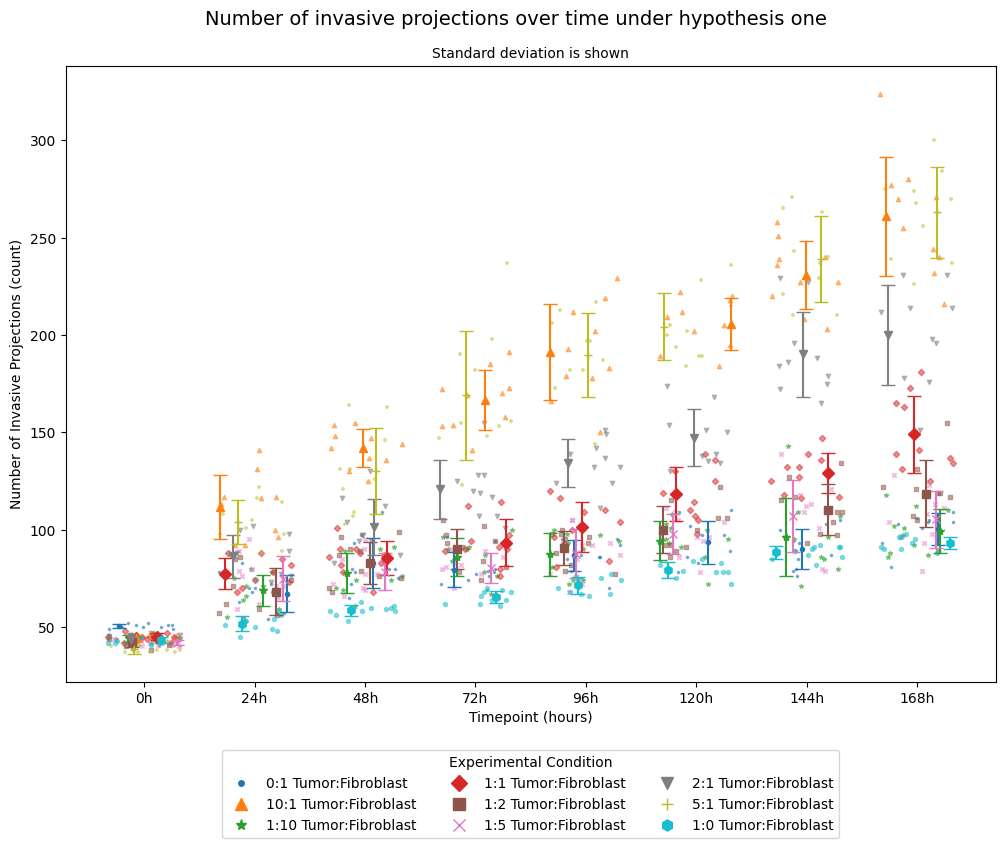

In [103]:
## Repeat of graph above, but using the standard deviation instead of the sem
# Group by 'experimental_condition' and 'timepoint'
grouped = hypo1_simulation_results_df.groupby(['experimental_condition', 'hours'])

# Calculate mean and standard deviation for each group
mean_sd_df = grouped['n_invasive_projections'].agg(['mean', 'std']).reset_index()

# Ensure data is sorted by 'timepoint'
mean_sd_df = mean_sd_df.sort_values(by=['hours'])

fig, ax = plt.subplots(figsize=(12,8))

# plot the points with jitter
i=0
for key, grp in hypo1_simulation_results_df.groupby(['experimental_condition']):
    jittered_timepoints = add_jitter(grp['hours'].values, jitter_amount=8)  # Add jitter to timepoints
    ax.scatter(
        list(jittered_timepoints), 
        grp['n_invasive_projections'], 
        marker=hour_markers[i], 
        alpha=0.5, 
        label=output_labels_map[key[0]], #grp['experimental_condition'].iloc[0],
        s = 10,
        color=colors[key[0]]
        )
    i += 1

# Plot the means with standard error bars
i=0
for key, grp in mean_sd_df.groupby('experimental_condition'):
    jittered_timepoints = add_jitter(grp['hours'].values, jitter_amount=8)  # Add jitter to timepoints
    # Add error bars for the mean with standard error
    ax.errorbar(
        list(jittered_timepoints), 
        grp['mean'], 
        yerr=grp['std'], 
        fmt=hour_markers[i], 
        capsize=5, 
        alpha=1.0, 
        color=colors[key]
        )
    i+=1

# Custom legend with alpha=1
handles, labels = ax.get_legend_handles_labels()
new_handles = []
for i, handle in enumerate(handles):
    new_handle = plt.Line2D([], [], color=colors[color_keys[i]], alpha=1.0, marker=hour_markers[i], linestyle='', markersize=8)
    new_handles.append(new_handle)

# Move the legend to below the x-axis
ax.legend(new_handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, title="Experimental Condition")

# set the axis ticks and labels
ax.set_xticks(xticks)  # Set the ticks
ax.set_xticklabels(xlabels)  # Set the tick labels
ax.set_title("Standard deviation is shown", fontsize=10)
ax.set_xlabel("Timepoint (hours)")
ax.set_ylabel("Number of Invasive Projections (count)")
fig.suptitle("Number of invasive projections over time under hypothesis one", fontsize=14, y=0.95)
plt.show()

## Figure Generation for Digitize Biology Paper Resubmission

In [22]:
## Plotting Utilities and Variables
def get_ratio_label(cat_str):
    if "only" in cat_str and "tumor" in cat_str:
        return f"1:0 Tumor:Fibroblast"
    elif "only" in cat_str and "fibroblast" in cat_str:
        return f"0:1 Tumor:Fibroblast"
    else:
        tumor = cat_str.split("_")[1]
        fibro = cat_str.split("_")[-2]
        return f"{tumor}:{fibro} Tumor:Fibroblast"

# Define jitter function to add random noise to the x-coordinates
def add_jitter(x, jitter_amount=0.1):
    return x + np.random.uniform(-jitter_amount, jitter_amount, size=len(x))

def plot_jitter_errbars(
    df,
    group_var,
    x_tick_var,
    x_label_var,
    y_var,
    ax=None,
    err_type='sem',
    condition_markers = ['.', '^', '*', 'D', 's', 'x', 'v', '+', 'h', 'o', '>', '<']
):

    # Use a color palette from Matplotlib's colormap (tab10 for 10 distinct colors)
    cmap = plt.get_cmap('tab10', len(df[group_var].unique()))
    colors = {condition: cmap(i) for i, condition in enumerate(df[group_var].unique())}
    color_keys = list(colors.keys())

    labels_raw = list(set(df[group_var]))
    labels_proc = [get_ratio_label(l) for l in labels_raw]
    output_labels_map = {k:p for k,p in zip(labels_raw, labels_proc)}

    # setting x axis ticks and labels
    xticks = list(np.unique(df[x_tick_var].values))
    xlabels = sorted(list(np.unique(df[x_label_var].values)), key=lambda x: int(''.join(filter(str.isdigit, str(x)))))

    # Group by 'experimental_condition' and 'timepoint'
    grouped = df.groupby([group_var, x_tick_var])

    # Calculate mean and standard error for each group
    mean_se_df = grouped[y_var].agg(['mean', err_type]).reset_index()

    # Ensure data is sorted by 'timepoint'
    mean_se_df = mean_se_df.sort_values(by=[x_tick_var])

    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
    

    # plot the points with jitter
    i=0
    for key, grp in df.groupby([group_var]):
        jittered_timepoints = add_jitter(grp[x_tick_var].values, jitter_amount=8)  # Add jitter to timepoints
        ax.scatter(
            list(jittered_timepoints), 
            grp[y_var], 
            marker=condition_markers[i], 
            alpha=0.5, 
            label=output_labels_map[key[0]], 
            s = 10,
            color=colors[key[0]]
            )
        i += 1

    # Plot the means with standard error bars
    i=0
    for key, grp in mean_se_df.groupby(group_var):
        jittered_timepoints = add_jitter(grp[x_tick_var].values, jitter_amount=8)  # Add jitter to timepoints
        # Add error bars for the mean with standard error
        ax.errorbar(
            list(jittered_timepoints), 
            grp['mean'], 
            yerr=grp[err_type], 
            fmt=condition_markers[i], 
            capsize=5, 
            alpha=1.0, 
            color=colors[key]
            )
        i+=1

    # Custom legend with alpha=1
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    for j, handle in enumerate(handles):
        label_color = handle.properties()['facecolor']
        new_handle = plt.Line2D([], [], color=label_color, alpha=1.0, marker=condition_markers[j], linestyle='', markersize=8)
        new_handles.append(new_handle)

    # Move the legend to below the x-axis
    ax.legend(new_handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

    # set the axis ticks and labels
    ax.set_xticks(xticks)  # Set the ticks
    ax.set_xticklabels(xlabels)  # Set the tick labels
    #ax.set_title("Standard error of the mean shown")
    #ax.set_xlabel("Timepoint (hours)")
    #ax.set_ylabel("Number of Invasive Projections (count)")

#fig.suptitle("Number of invasive projections over time under hypothesis two", y=.95)
#plt.show()

In [ ]:
# matching the same conditions as the random ics experiments
hypo1 = hypo1_simulation_results_df
hypo1 = hypo1[hypo1['experimental_condition'] != 'fibroblast_only']
hypo2 = hypo2_simulation_results_df
hypo2 = hypo2[hypo2['experimental_condition'] != 'fibroblast_only']

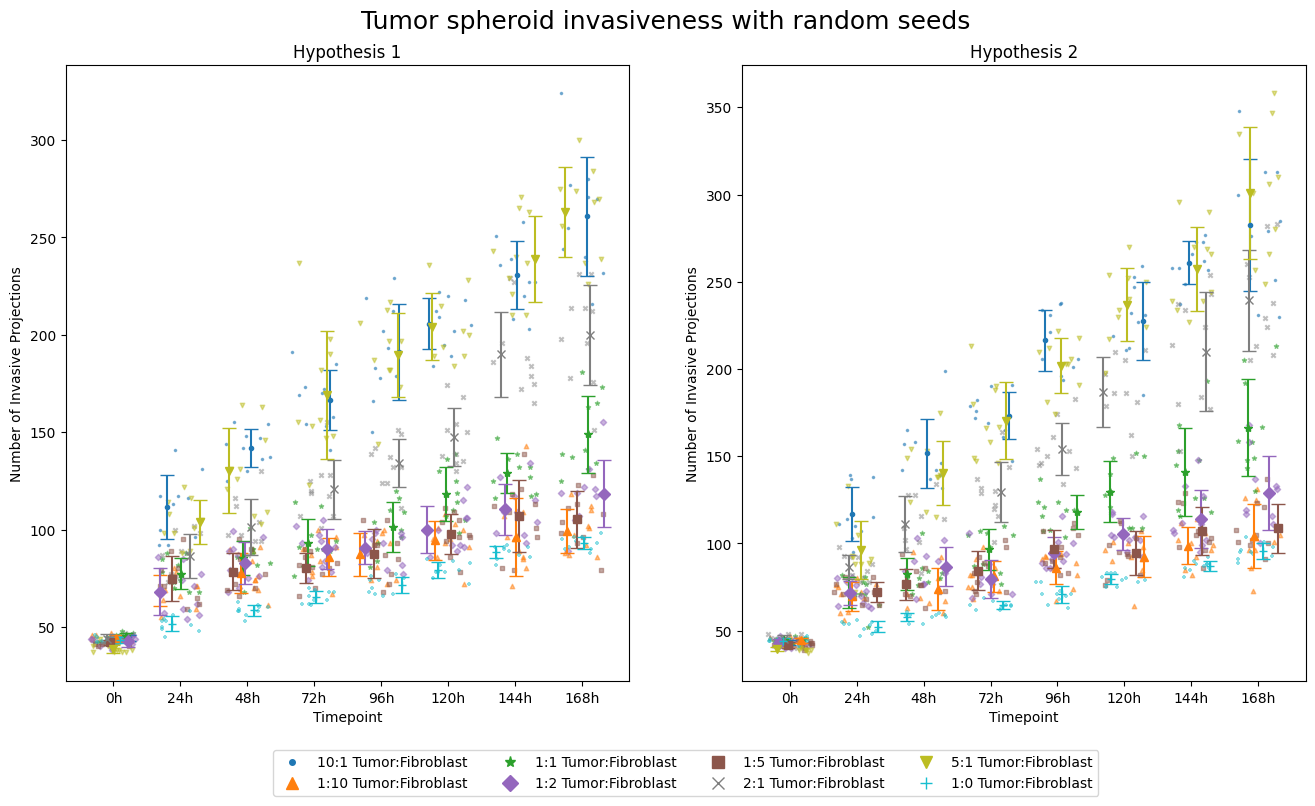

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax = ax.ravel()
plot_jitter_errbars(
    hypo1, 
    group_var = 'experimental_condition', 
    x_tick_var = 'hours', 
    x_label_var = 'timepoint', 
    y_var = 'n_invasive_projections',
    ax = ax[0],
    err_type='std'
)
ax[0].set_title('Hypothesis 1')
ax[0].set_ylabel('Number of Invasive Projections')
ax[0].set_xlabel('Timepoint')
ax[0].get_legend().remove()

plot_jitter_errbars(
    hypo2, 
    group_var = 'experimental_condition', 
    x_tick_var = 'hours', 
    x_label_var = 'timepoint', 
    y_var = 'n_invasive_projections',
    ax = ax[1],
    err_type='std'
)
ax[1].set_title('Hypothesis 2')
ax[1].set_ylabel('Number of Invasive Projections')
ax[1].set_xlabel('Timepoint')

# add and enhance legend
condition_markers = ['.', '^', '*', 'D', 's', 'x', 'v', '+', 'h', 'o', '>', '<']
handles, labels = ax[1].get_legend_handles_labels()
new_handles = []
for j, handle in enumerate(handles):
    label_color = handle.properties()['facecolor']
    new_handle = plt.Line2D([], [], color=label_color, alpha=1.0, marker=condition_markers[j], linestyle='', markersize=8)
    new_handles.append(new_handle)
ax[1].legend(new_handles, labels, bbox_to_anchor=[-0.1, -0.1], ncol=4, loc='upper center')

fig.suptitle('Tumor spheroid invasiveness with random seeds', y=0.95, fontsize=18)
plt.savefig("../output/figures/invasiveness_randomized_seeds.pdf", dpi=300, bbox_inches='tight')
plt.show()